In [3]:
import os
import sys
import requests
import pandas as pd
import numpy as np
import QuantLib as ql
from pathlib import Path
import matplotlib.pyplot as plt
from tqdm import tqdm
from itertools import product
from datetime import datetime
from datetime import timedelta
import model_settings
from model_settings import ms
from historical_av_plot_vol_surface import plot_vol_surface
fontsize=6
plt.rcParams.update(
    {
        'axes.labelsize': fontsize,
        'xtick.labelsize': fontsize,
        'ytick.labelsize': fontsize,
        'figure.titlesize': fontsize,
        'axes.linewidth': 1/3,
    }
)
search_symbol = 'SPY'
url = f"https://www.alphavantage.co/query?function=SYMBOL_SEARCH&keywords={search_symbol}&apikey={ms.av_key}"
r = requests.get(url)
data = r.json()
pd.DataFrame(data['bestMatches'])

,1. symbol,2. name,3. type,4. region,5. marketOpen,6. marketClose,7. timezone,8. currency,9. matchScore
0,SPY,SPDR S&P 500 ETF Trust,ETF,United States,09:30,16:00,UTC-04,USD,1.0000
1,SPY1.FRK,SSgA SPDR ETFs Europe I Public Limited Company...,ETF,Frankfurt,08:00,20:00,UTC+02,EUR,0.6667
2,SPY2.FRK,SSgA SPDR ETFs Europe I Public Limited Company...,ETF,Frankfurt,08:00,20:00,UTC+02,EUR,0.6667
3,SPY3.LON,Leverage Shares 3x Long US 500 ETP Securities,ETF,United Kingdom,08:00,16:30,UTC+01,USD,0.6667
4,SPY4.FRK,SSgA SPDR S&P 400 US Mid Cap,ETF,Frankfurt,08:00,20:00,UTC+02,EUR,0.6667
5,SPY4.LON,SPDR® S&P 400 US Mid Cap UCITS ETF,ETF,United Kingdom,08:00,16:30,UTC+01,USD,0.6667
6,SPY1.DEX,SPDR® S&P 500 Low Volatility UCITS ETF,ETF,XETRA,08:00,20:00,UTC+02,EUR,0.6000
7,SPY2.DEX,SPDR® Dow Jones Global Real Estate UCITS ETF U...,ETF,XETRA,08:00,20:00,UTC+02,EUR,0.6000
8,SPY4.DEX,SSgA SPDR S&P 400 US Mid Cap,ETF,XETRA,08:00,20:00,UTC+02,EUR,0.6000
9,SPY4.PAR,SSgA SPDR S&P 400 US Mid Cap,ETF,Paris,09:00,17:30,UTC+02,EUR,0.6000


In [4]:
symbol=search_symbol
url = str(
	'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol='+
	symbol+'&outputsize=full&apikey='+
	ms.av_key)
print(symbol)
r = requests.get(url)
spots = pd.Series(pd.DataFrame(r.json()['Time Series (Daily)']).transpose()['4. close'].squeeze())
spots = pd.to_numeric(spots,errors='coerce')
print(spots)

SPY
2024-10-15    579.7800
2024-10-14    584.3200
2024-10-11    579.5800
2024-10-10    576.1300
2024-10-09    577.1400
                ...   
1999-11-05    137.8750
1999-11-04    136.5312
1999-11-03    135.5000
1999-11-02    134.5937
1999-11-01    135.5625
Name: 4. close, Length: 6279, dtype: float64


# example data collection

let us collect a few recent trading days and inspect the data

In [5]:
dates = spots.index
dates = pd.Series(dates[:5])
print(dates)

0    2024-10-15
1    2024-10-14
2    2024-10-11
3    2024-10-10
4    2024-10-09
dtype: object


In [6]:
from historical_alphaVantage_collection import collect_av_link
chain = {}
bar = tqdm(total=len(dates))
for date in dates:
    spot = float(spots[date])
    link = collect_av_link(date,spot,symbol)
    printdate = datetime.strptime(date, '%Y-%m-%d').strftime('%A, %Y-%m-%d')
    chain[date] = link
    bar.update(1)
bar.close()

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:07<00:00,  1.43s/it]


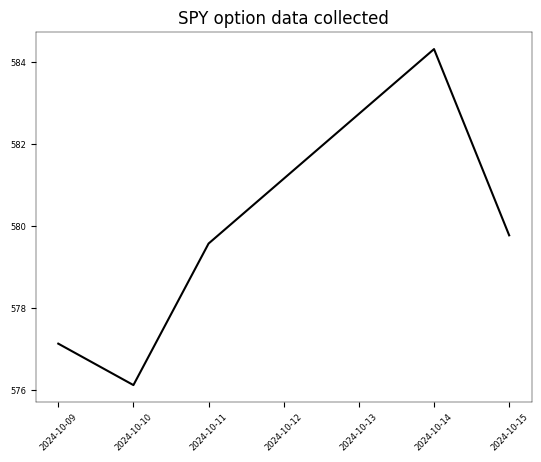

<Figure size 640x480 with 0 Axes>

In [7]:
demo_spots = spots[dates]
demo_spots.index = pd.to_datetime(demo_spots.index, format='%Y-%m-%d')
plt.figure()
plt.plot(demo_spots,color='black')
plt.title(f'{symbol} option data collected')
plt.xticks(rotation=45)
plt.show()
plt.clf()

# example calibraion

now why not select the one trading day and porceed with an example calibration of our Heston (1993) model

In [8]:
date = dates[2]
raw_data = chain[date]
calculation_datetime = datetime.strptime(date,'%Y-%m-%d')
calculation_date = ql.Date(
    calculation_datetime.day,
    calculation_datetime.month,
    calculation_datetime.year,
)
notebook_printdate = str(calculation_datetime.strftime('%A, '))+str(calculation_date)
print(notebook_printdate)

Friday, October 11th, 2024


## modelling the volatility surface


SPY spot price: 577.14


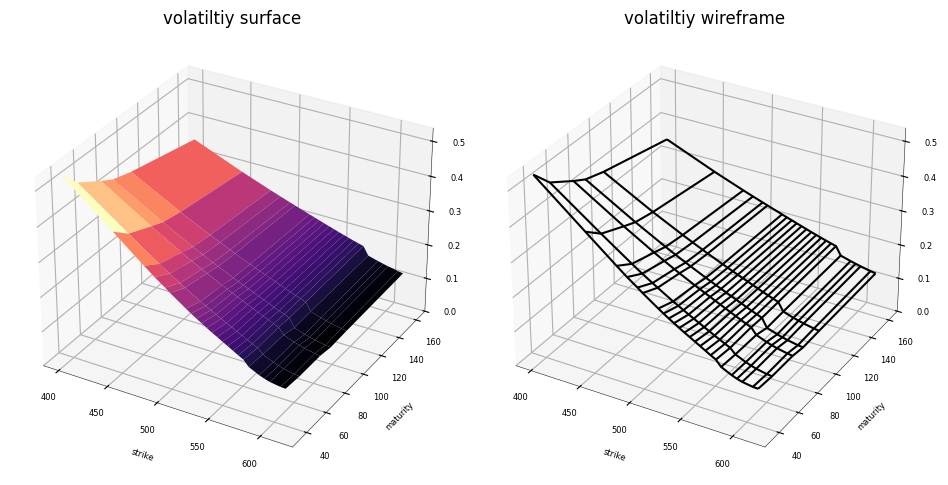

,35,49,70,81,98,161
400.0,0.53705,0.48293,0.43827,0.41723,0.39970,0.35199
450.0,0.41997,0.38019,0.34985,0.33507,0.32333,0.29376
480.0,0.35001,0.32043,0.30016,0.28903,0.28141,0.26175
490.0,0.32729,0.30138,0.28431,0.27470,0.26815,0.25153
500.0,0.30656,0.28339,0.26937,0.26053,0.25504,0.24163
505.0,0.29544,0.27440,0.26190,0.25382,0.24849,0.23660
520.0,0.26510,0.24864,0.24041,0.23385,0.23004,0.22211
525.0,0.25534,0.24071,0.23370,0.22745,0.22410,0.21724
530.0,0.24605,0.23278,0.22684,0.22105,0.21815,0.21251
535.0,0.23720,0.22486,0.22028,0.21495,0.21221,0.20763


<Figure size 640x480 with 0 Axes>

In [9]:
df = raw_data.copy()
df['volume'] = pd.to_numeric(df['volume'])
df['implied_volatility'] = pd.to_numeric(df['implied_volatility'])
df['strike'] = pd.to_numeric(df['strike'])
df['volume'] = pd.to_numeric(df['volume'])
df['expiration'] = pd.to_datetime(df['expiration'],format='%Y-%m-%d')
df['date'] = pd.to_datetime(df['date'],format='%Y-%m-%d')
df['days_to_maturity'] = df['expiration'] - df['date']
df['days_to_maturity'] = df['days_to_maturity'] / np.timedelta64(1, 'D')
df['days_to_maturity'] = df['days_to_maturity'].astype('int64')
df = df[(df['days_to_maturity']>=30)&(df['days_to_maturity']<=400)]
df = df[df['volume']>0].copy()
df['spot_price'] = spot
df['moneyness'] = ms.vmoneyness(df['spot_price'],df['strike'],df['type'])
df = df[(df['moneyness']<0)&(df['moneyness']>-0.5)]
indexed = df.copy().set_index(['strike','days_to_maturity'])

T = np.sort(df['days_to_maturity'].unique()).tolist()
K = np.sort(df['strike'].unique()).tolist()
volume_heatmap = pd.DataFrame(
    np.full((len(K), len(T)), np.nan), index=K, columns=T)
for k in K:
    for t in T:
        try:
            volume_heatmap.loc[k,t] = indexed.loc[(k,t),'volume']
        except Exception:
            pass
        
        
hottest_contracts = pd.DataFrame(
    volume_heatmap.unstack().sort_values(
        ascending=False)).head(50).reset_index()
hottest_contracts.columns = ['t','k','volume']
T = np.sort(hottest_contracts['t'].unique()).tolist()
K = np.sort(hottest_contracts['k'].unique()).tolist()

vol_matrix = pd.DataFrame(
    np.full((len(K),len(T)),np.nan),
    index = K,
    columns = T
)
for k in K:
    for t in T:
        try:
            vol_matrix.loc[k,t] = indexed.loc[(k,float(t)),'implied_volatility']
        except Exception:
            pass

vol_matrix = vol_matrix.dropna().copy()
T = vol_matrix.columns.tolist()
K = vol_matrix.index.tolist()

cols_to_map = [
        'contractID', 'symbol', 'expiration', 'type', 'last', 'mark',
        'bid', 'bid_size', 'ask', 'ask_size', 'volume', 'open_interest', 'date',
        'implied_volatility', 'delta', 'gamma', 'theta', 'vega', 'rho',
        'spot_price', 'moneyness'
]
for col in cols_to_map:
    for i,row in hottest_contracts.iterrows():
        hottest_contracts.at[i,col] = indexed.loc[(row['k'],row['t']),col]
        
hottest_contracts = hottest_contracts.rename(
    columns={'t':'days_to_maturity','k':'strike_price'}).copy()

s = float(df['spot_price'].unique()[0])
print(f"\n{symbol} spot price: {s}")
plot_vol_surface(vol_matrix)
vol_matrix

## calibrating a Heston (1993) model

In [10]:
vol_matrix = vol_matrix.sort_index().drop_duplicates()
pd.to_numeric(raw_data['last'])
raw_data['date'] = pd.to_datetime(raw_data['date'])
raw_data['expiration'] = pd.to_datetime(raw_data['expiration'])
raw_data['implied_volatility'] = pd.to_numeric(raw_data['implied_volatility']).astype(float)
raw_data['strike'] = pd.to_numeric(raw_data['strike'])
raw_data['last'] = pd.to_numeric(raw_data['last'])
contract_maturities = np.array((raw_data['expiration'] - raw_data['date']) / timedelta(days=1)).astype(int)
raw_data['days_to_maturity'] = contract_maturities

T = vol_matrix.columns.tolist()
K = vol_matrix.index.tolist()
r = 0.04
g = 0.0

ql.Settings.instance().evaluationDate = calculation_date
flat_ts, dividend_ts = ms.ql_ts_rg(r, g, calculation_date)
S_handle = ql.QuoteHandle(ql.SimpleQuote(s))

heston_helpers = []
v0 = 0.01; kappa = 0.2; theta = 0.02; rho = -0.75; eta = 0.5;
process = ql.HestonProcess(
    flat_ts,
    dividend_ts,
    S_handle,
    v0,                # Initial volatility
    kappa,             # Mean reversion speed
    theta,             # Long-run variance (volatility squared)
    eta,               # Volatility of the volatility
    rho                # Correlation between asset and volatility
)
model = ql.HestonModel(process)
engine = ql.AnalyticHestonEngine(model)

for t in T:
    for k in K:
        p = ql.Period(int(t),ql.Days)
        volatility = vol_matrix.loc[k,t]
        helper = ql.HestonModelHelper(
            p, ms.calendar, float(s), k, 
            ql.QuoteHandle(ql.SimpleQuote(volatility)), 
            flat_ts, 
            dividend_ts
            )
        helper.setPricingEngine(engine)
        heston_helpers.append(helper)

lm = ql.LevenbergMarquardt(1e-8, 1e-8, 1e-8)


model.calibrate(heston_helpers, lm,
                  ql.EndCriteria(1000, 50, 1.0e-8,1.0e-8, 1.0e-8))

theta, kappa, eta, rho, v0 = model.params()
heston_parameters = pd.Series(
    [theta, kappa, eta, rho, v0],
    index = ['theta', 'kappa', 'eta', 'rho', 'v0'],
    dtype = float
)
calibration_test_data = raw_data.copy()[['strike','type','last','implied_volatility','days_to_maturity']]
calibration_test_data.columns = ['strike_price','w','market_price','volatility','days_to_maturity']
calibration_test_data['spot_price'] = s
calibration_test_data['risk_free_rate'] = r
calibration_test_data['dividend_rate'] = g
calibration_test_data = calibration_test_data[calibration_test_data['days_to_maturity'].isin(df['days_to_maturity'])]
calibration_test_data[heston_parameters.index.tolist()] = np.tile(heston_parameters,(calibration_test_data.shape[0],1))
calibration_test_data.loc[:,'moneyness'] = ms.vmoneyness(
    calibration_test_data['spot_price'].values,
    calibration_test_data['strike_price'].values,
    calibration_test_data['w'].values)
calibration_test_data['calculation_date'] = calculation_datetime
calibration_test_data['black_scholes'] = ms.vector_black_scholes(calibration_test_data)
calibration_test_data['heston_price'] = ms.vector_heston_price(calibration_test_data)
calibration_test_data.loc[:,'error'] = calibration_test_data['heston_price'].values - calibration_test_data['black_scholes'].values
avg = np.mean(np.abs(calibration_test_data['error']))
print(f"\n{printdate}\n{heston_parameters}\naverage absolute error: {round(avg,3)}")
print(f"calibration testing dataset:\n{calibration_test_data.describe()}")


Wednesday, 2024-10-09
theta    0.055113
kappa    7.109954
eta      3.991767
rho     -0.672790
v0       0.049050
dtype: float64
average absolute error: 2.872
calibration testing dataset:
       strike_price  market_price   volatility  days_to_maturity  spot_price  \
count   4722.000000   4722.000000  4722.000000       4722.000000     4722.00   
mean     515.975011     44.338299     0.231191        167.308767      577.14   
min      120.000000      0.000000     0.012450         35.000000      577.14   
25%      453.000000      0.000000     0.159160         70.000000      577.14   
50%      527.000000      7.350000     0.203060        140.000000      577.14   
75%      585.000000     61.515000     0.271772        262.000000      577.14   
max      830.000000    461.370000     1.061270        354.000000      577.14   
std      127.349300     73.214132     0.126206        107.049704        0.00   

       risk_free_rate  dividend_rate         theta         kappa  \
count         4722.00   

# train data generation

In [11]:
strike_spread = 0.2
K = np.linspace(
    int(s*(1-strike_spread)),
    int(s*(1+strike_spread)),
    7
).astype(int).tolist()

barrier_step = 10
down_barriers =  np.linspace(
    s*0.5,
    s*0.99,
    5
).astype(int).tolist()

T = [
    30,60,90,
    180,360,540,720
]
print(f"\n{symbol} spot price:\n     {spot}\n\nstrikes:\n     {K}\n\nbarriers:\n     {down_barriers}\n\nmaturities:\n     {T}\n")


SPY spot price:
     577.14

strikes:
     [461, 499, 538, 576, 615, 653, 692]

barriers:
     [288, 359, 429, 500, 571]

maturities:
     [30, 60, 90, 180, 360, 540, 720]



In [12]:
print('generating contracts...')
features = pd.DataFrame(
    product(
        [spot],
        K,
        T,
        down_barriers,
        [0.0], # rebate
        ['put','call'],
        [0.04], # risk-free rate
        [0.0], # dividend rate
        [theta], 
        [kappa], 
        [eta], 
        [rho], 
        [v0],
        [calculation_datetime],
        ['Out','In']
    ),
    columns = [
        'spot_price',
        'strike_price',
        'days_to_maturity',
        'barrier',
        'rebate',
        'w',
        'risk_free_rate',
        'dividend_rate',
        'theta', 'kappa', 'eta', 'rho', 'v0',
        'calculation_date',
        'outin',
    ]
)
features['moneyness'] = ms.vmoneyness(features['spot_price'],features['strike_price'],features['w'])
features['barrier_type_name'] = 'Down' + features['outin']
print('contracts generated')
print(f'pricing {features.shape[0]} contracts...')
features['vanilla_price'] = ms.vector_heston_price(features)
features['barrier_price'] = ms.vector_barrier_price(features)
featuresby_t = features.copy().set_index('days_to_maturity')
print('priced!')

generating contracts...
contracts generated
pricing 980 contracts...
priced!


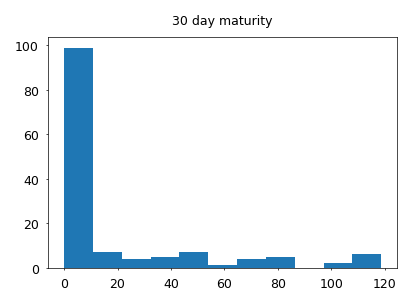

<Figure size 640x480 with 0 Axes>

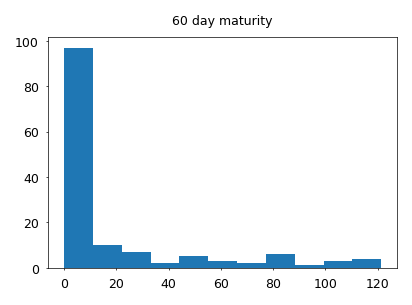

<Figure size 640x480 with 0 Axes>

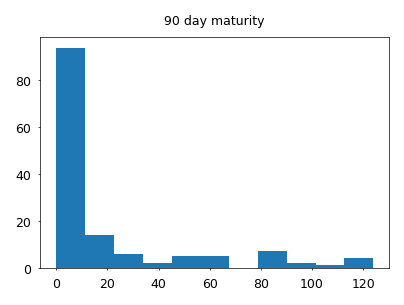

<Figure size 640x480 with 0 Axes>

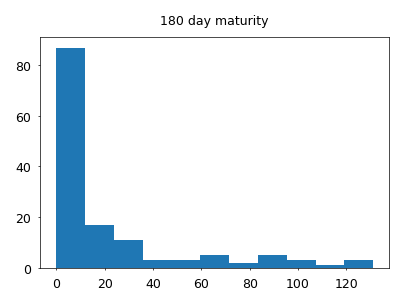

<Figure size 640x480 with 0 Axes>

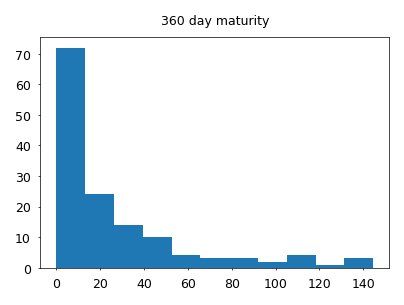

<Figure size 640x480 with 0 Axes>

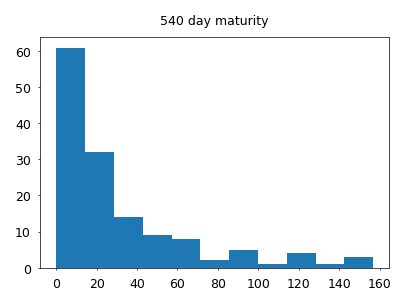

<Figure size 640x480 with 0 Axes>

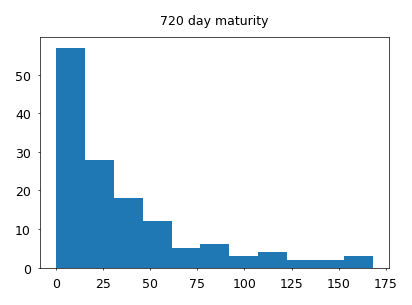

<Figure size 640x480 with 0 Axes>

In [13]:
for t in T:
    plt.figure(figsize=(3, 2), dpi=150)
    prices= featuresby_t.loc[t,'barrier_price']
    plt.hist(prices,bins=int(np.sqrt(prices.shape[0])))
    plt.tick_params(axis='both', which='major', length=1, width=1/3)  # Thinner tick marks
    plt.title(f'{t} day maturity', fontsize=fontsize)
    plt.show()
    plt.clf()

# model training

In [14]:
import convsklearn
help(convsklearn)

Help on package convsklearn:

NAME
    convsklearn - a proprietary package of convenience wrappers for sklearn

PACKAGE CONTENTS
    convsklearn

DATA
    barrier_trainer = <convsklearn.convsklearn.convsklearn object>
    categorical_features = ['barrier_type_name', 'w']
    feature_set = ['spot_price', 'strike_price', 'days_to_maturity', 'risk...
    numerical_features = ['spot_price', 'strike_price', 'days_to_maturity'...
    target_name = 'observed_price'
    target_transformer_pipeline = Pipeline(steps=[('StandardScaler', Stand...
    transformers = [('StandardScaler', StandardScaler(), ['spot_price', 's...

FILE
    e:\python\lib\site-packages\convsklearn\__init__.py




In [15]:
from convsklearn import target_name, numerical_features, categorical_features, transformers, target_transformer_pipeline

In [16]:
barrier_trainer = convsklearn.convsklearn(
    target_name=target_name, 
    numerical_features=numerical_features, 
    categorical_features=categorical_features, 
    transformers=transformers, 
    target_transformer_pipeline=target_transformer_pipeline, 
    max_iter=1000
)

In [17]:
features['observed_price'] = ms.noisyfier(features.loc[:,'barrier_price']) 
    # apply slight peturbation in the form of a random normal with standard deviation 0.15
train_data = features[features['days_to_maturity']!=720]
test_data = features[features['days_to_maturity']==720]
print(f"train data count: {train_data.shape[0]}")
print(f"test data count: {test_data.shape[0]}")
arrs = barrier_trainer.get_train_test_arrays(train_data,test_data)
train_X = arrs['train_X']
train_y = arrs['train_y']
test_X = arrs['test_X']
test_y = arrs['train_y']
preprocessor = barrier_trainer.preprocess()
dnn_barriers, runtime, specs = barrier_trainer.run_dnn(preprocessor, train_X, train_y)
in_sample, out_of_sample, errors = barrier_trainer.test_prediction_accuracy(dnn_barriers, test_data, train_data)
outsample = out_of_sample.rename(
    columns = {
        'strike_price':'k',
        'days_to_maturity':'t',
        'barrier_type_name':'type',
        'barrier_price':'price',
        'vanilla_price':'vanilla',
        'spot_price':'spot',
        'outofsample_target':'target',
        'outofsample_prediction':'dnn',
        'outofsample_error':'error',
        'barrier':'b'
        }
)
outsample = outsample[[
    'spot', 'k', 'b','price', 'vanilla', 'type', 'w','t', 
    'target', 'dnn', 'error'
]]
print(f"\n{dnn_barriers}")

train data count: 840
test data count: 140

training...

Deep Neural Network
hidden layers sizes: (13, 13, 13)
learning rate: adaptive
activation: relu
solver: sgd
alpha: 0.0001

in sample:
     RSME: 7.776548962898259
     MAE: 5.086826717819297

out of sample:
     RSME: 13.73329903829595
     MAE: 9.463421837108594

TransformedTargetRegressor(regressor=Pipeline(steps=[('preprocessor',
                                                      ColumnTransformer(transformers=[('StandardScaler',
                                                                                       StandardScaler(),
                                                                                       ['spot_price',
                                                                                        'strike_price',
                                                                                        'days_to_maturity',
                                                                                     

In [18]:
pd.set_option("display.float_format", "{:.2f}".format)
pd.set_option("display.max_rows",None)
print(f"\n{outsample.describe()}")
outsample_preview = outsample.copy().sort_values(by=['w','type','k','b'],ascending=False).reset_index(drop=True)
print(f"\n{symbol} down barrier options for {notebook_printdate}")
outsample_preview


        spot      k      b  price  vanilla      t  target    dnn  error
count 140.00 140.00 140.00 140.00   140.00 140.00  140.00 140.00 140.00
mean  577.14 576.29 429.40  34.10    68.44 720.00   34.10  33.36  -0.74
std     0.00  77.28 100.34  39.44    44.28   0.00   39.44  32.87  13.76
min   577.14 461.00 288.00   0.00    18.20 720.00    0.00  -2.57 -64.24
25%   577.14 499.00 359.00   3.43    31.17 720.00    3.38   8.79  -7.61
50%   577.14 576.00 429.00  22.35    57.04 720.00   22.29  22.80  -0.27
75%   577.14 653.00 500.00  47.45    88.69 720.00   47.53  48.93   5.23
max   577.14 692.00 571.00 168.43   169.31 720.00  168.48 152.67  47.73

SPY down barrier options for Friday, October 11th, 2024


,spot,k,b,price,vanilla,type,w,t,target,dnn,error
0,577.14,692,571,0.59,88.69,DownOut,put,720,0.42,11.62,11.19
1,577.14,692,500,10.40,88.69,DownOut,put,720,10.40,22.56,12.15
2,577.14,692,429,24.07,88.69,DownOut,put,720,24.37,33.07,8.70
3,577.14,692,359,38.13,88.69,DownOut,put,720,38.31,50.09,11.78
4,577.14,692,288,51.65,88.69,DownOut,put,720,51.51,51.22,-0.29
5,577.14,653,571,0.12,68.16,DownOut,put,720,0.27,3.27,3.00
6,577.14,653,500,4.21,68.16,DownOut,put,720,4.05,9.27,5.23
7,577.14,653,429,12.91,68.16,DownOut,put,720,12.85,19.39,6.55
8,577.14,653,359,23.53,68.16,DownOut,put,720,23.55,29.37,5.82
9,577.14,653,288,34.69,68.16,DownOut,put,720,34.51,35.37,0.86


In [17]:
pd.reset_option("display.max_rows")
pd.reset_option("display.float_format") 